In [63]:
import sys
sys.path.append("../../src/earthtext")
import geopandas as gpd
import shapely as sh
from pyproj import CRS
epsg4326 = CRS.from_epsg(4326)
import pandas as pd
from progressbar import progressbar as pbar
import numpy as np
import matplotlib.pyplot as plt
from osm import osm
from importlib import reload
import geoplot
reload(osm)

<module 'osm.osm' from '/home/ubuntu/earth-text/notebooks/osm/../../src/earthtext/osm/osm.py'>

## load boundaries of California


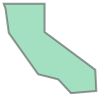

In [2]:

cc = gpd.read_file("/opt/data/osm/CA_State_TIGER2016.shp").to_crs(epsg4326)
c = cc.geometry[0]
c = list(c.geoms)[6].simplify(tolerance=.5)
caldf = gpd.GeoDataFrame(geometry=[c], crs=epsg4326)
c

## run OSM queries on the `pbf` file dump

In [29]:
reload(osm)
nc = osm.OSMSimpleHandler(pbf_filepath='/opt/data/osm/norcal-latest.osm.pbf')

In [30]:
nc.apply(only_tag='natural')

- |                                          # | 75067310 Elapsed Time: 0:03:18

In [31]:
len(nc.nodes), len(nc.ways)

(136260, 126819)

In [7]:
sum([len(n.nodes) for n in ao.nodes.values()])

5527

In [45]:
k = list(nc.nodes.values())[0]
k.copy()

{'tags': {'ele': '548',
  'mountain_pass': 'yes',
  'name': 'Patchen Pass',
  'name:etymology': 'Patchen',
  'name:etymology:wikidata': 'Q7144355',
  'natural': 'saddle',
  'note': 'Signposted as 1800 feet; county line is located at the pass by law',
  'wikidata': 'Q30588010',
  'wikipedia': 'en:Patchen Pass'},
 'geometry': <POINT (-121.985 37.144)>}

In [36]:
sum(['geometry' not in v for k,v in nc.nodes.items()])

0

In [55]:
gg = []
for k,v in nc.nodes.items():
    d = v['tags'].copy()
    d['geometry'] = v['geometry']
    d['id'] = k
    gg.append(d)

gg = gpd.GeoDataFrame(gg, crs=epsg4326)

In [56]:
gg.to_parquet(f"/opt/data/osm/california_osm_{key}_node.parquet")

In [57]:
key = 'natural'
gcc = gg[key].value_counts()
gcc.index = [f"{k} {v:8d}" for k,v in dict(gcc).items()]

(0.0, 10000.0)

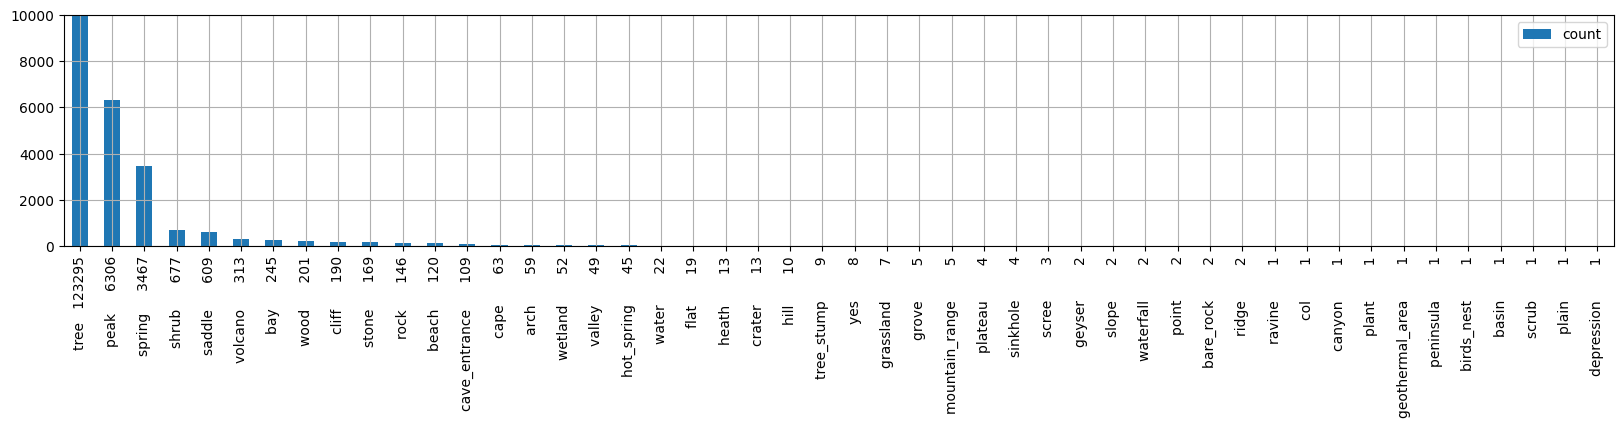

In [60]:
pd.DataFrame(gcc).plot(kind='bar', figsize=(20,3))
plt.grid()
plt.ylim(0,10000)

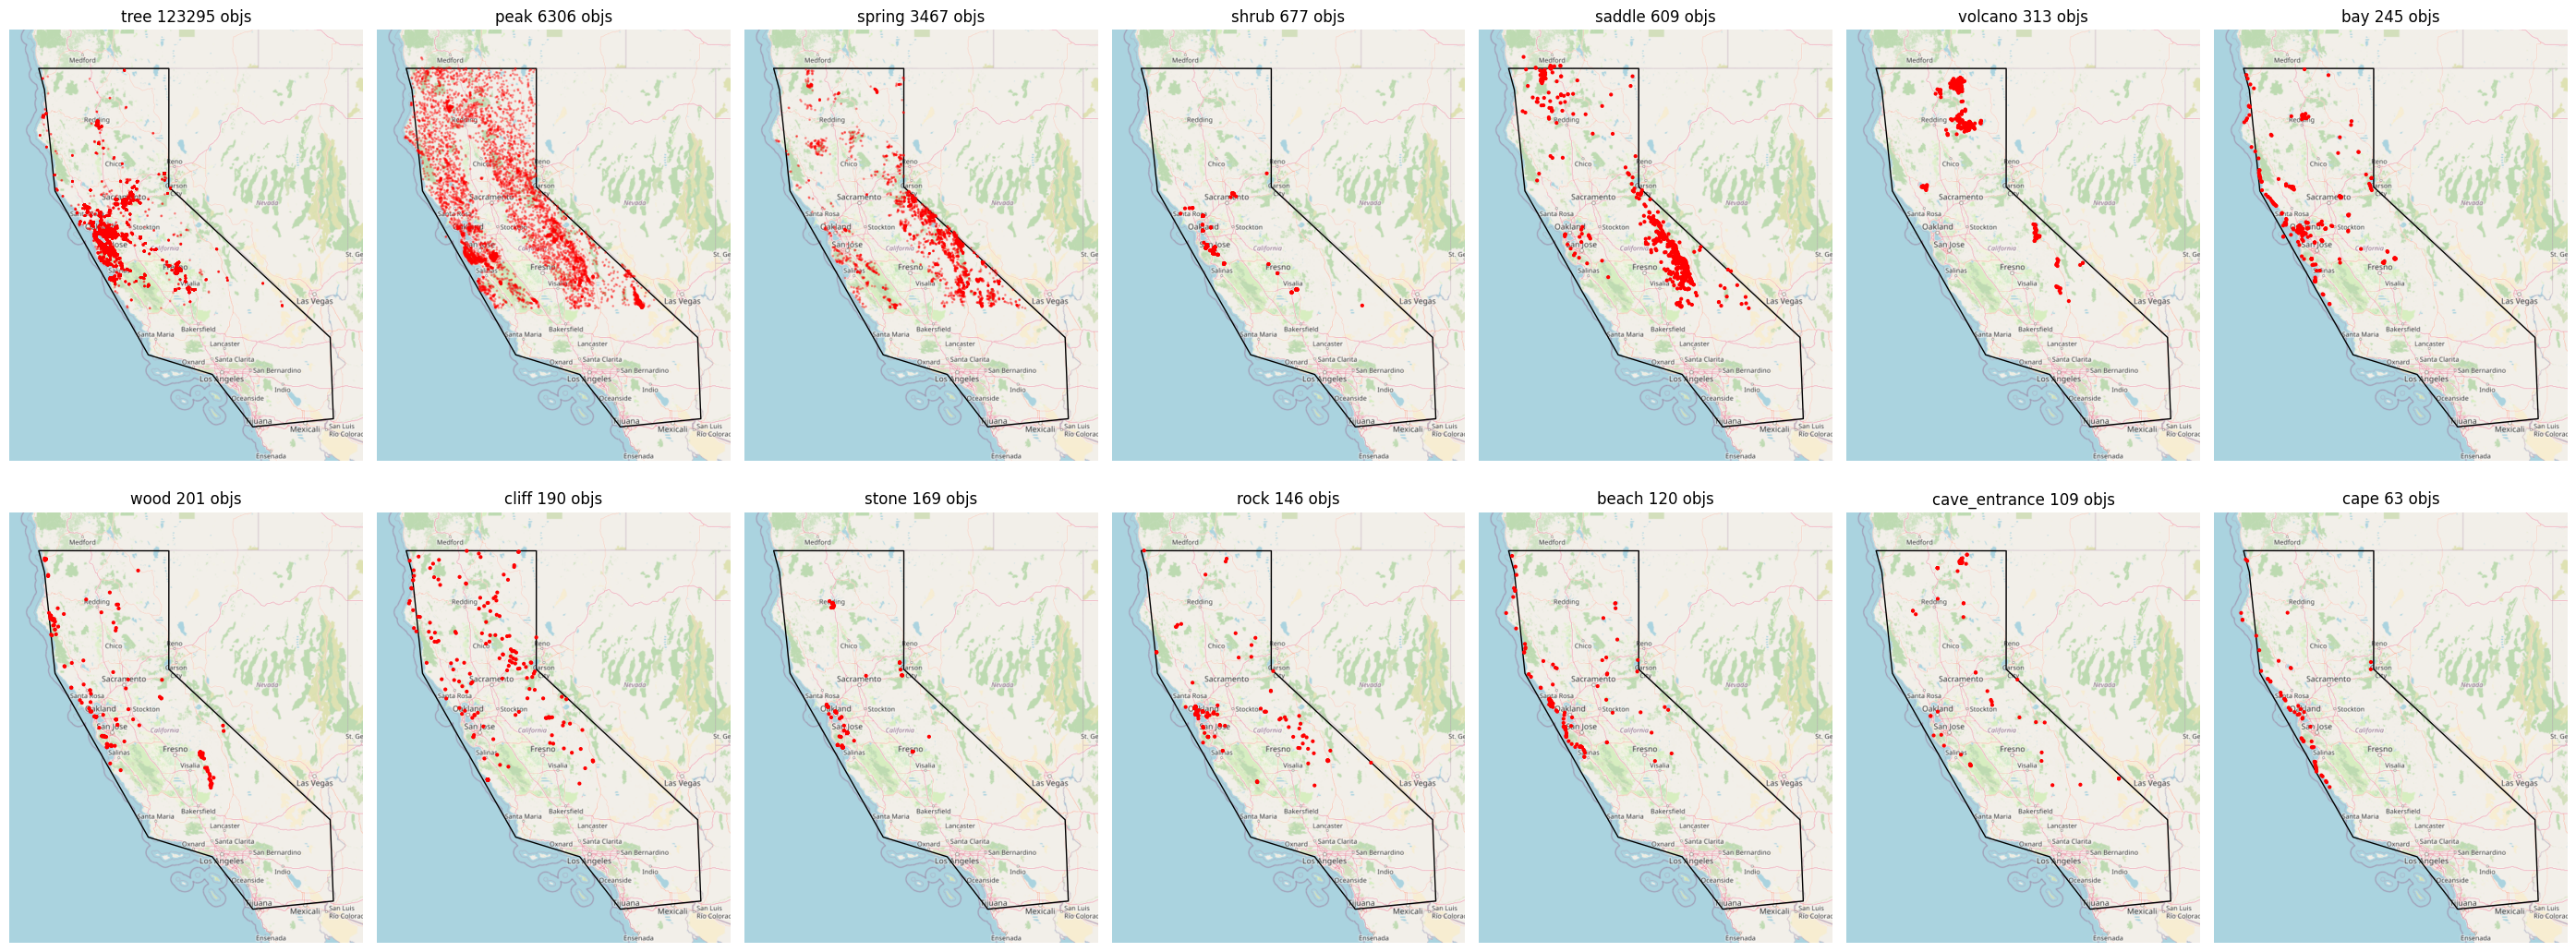

In [69]:
gcc = gg[key].value_counts()
for ax,feature in osm.subplots(gcc.iloc[:14].index, n_cols=7, usizex=4, usizey=5.5, projection=geoplot.crs.WebMercator()):
    x = gg[gg[key]==feature]
    lenx = len(x)
    if len(x)>50000: x=x.sample(50000)
    plt.title(f"{feature} {lenx} objs")
    geoplot.webmap(gpd.GeoDataFrame(geometry=[c], crs=epsg4326), ax=ax)
    alpha = 1 if len(x)<3000 else 0.3
    size = 2 if len(x)<3000 else 1
    geoplot.pointplot(x, ax=ax, alpha=alpha, s=size, color='red')
    geoplot.polyplot(caldf, ax=ax)
